In [383]:
import numpy as np
from tqdm import tqdm

class budget_optimizer:

    def __init__(self,T,budget,params):
        
        #init_allocation = np.flip(np.arange(T+1))+1
        init_allocation = np.repeat(1,T+1)

        self.init_X = (init_allocation/sum(init_allocation))*budget
        self.M = budget
        self.T = T
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.lambd = params['lambd']

    @staticmethod
    def utility(x, gamma):
        return x**gamma

    @staticmethod
    def u_1st(x, gamma):
        return gamma*x**(gamma-1)

    @staticmethod
    def w_up(u,lambd):
        return np.exp(u/lambd)

    @staticmethod
    def default_w(T,delta):
        return delta**np.arange(T+1)
    
    @staticmethod
    def neg_adjust(x,M,neg_adjust = 1e-4):   
 
        # adjust negative x to tiny positive number
       
        if sum(x <= 0)>0:
            x_neg_adjust = (x <= 0) * neg_adjust 
            x_nonneg_adjust = (x > neg_adjust) * x - sum(x_neg_adjust) / sum(x > neg_adjust)

            x_adjust = neg_adjust + (x > neg_adjust)*x_nonneg_adjust + ((x<=neg_adjust) & (x>0))*x
        else:
            x_adjust = x

        return x_adjust / sum(x_adjust) * M


    def grad_func(self,x,d):
    
        u = self.utility(x,self.gamma) 
        u_prime = self.u_1st(x,self.gamma)
        w_upper = self.w_up(u,self.lambd) * d
        
        w = w_upper / sum(w_upper)
        V = w @ u
        G = w * (u+1-V) * u_prime

        obj = -np.log(V)
        grad = -G/V
    
        return obj, grad
    
    def proj_func(self,x):
        return x + (self.M-sum(x))/len(x)

    def solve(self,init_x = None, stepsize = 0.1, iters = 10000, tol = 1e-6, 
              diffusion = 1e-3, a_grid = np.arange(4)/3,
              break_point = np.Inf):

        d = self.default_w(self.T,self.delta)

        if init_x is None:
            x_0 = self.init_X
        else:
            x_0 = init_x
            
        obj_0, grad_0 = self.grad_func(x_0,d)
        self.fn = [obj_0]

        for i in tqdm(range(iters)):

            fn_min = min(self.fn)
            
            # Projection Gradient Descent (PG)
            y = x_0 - stepsize * grad_0
            x_1 = self.proj_func(y)

            # adjust negative x to tiny positive
            x_pg = self.neg_adjust(x_1,M=self.M)


            # new obj and grad
            obj_pg, grad_pg = self.grad_func(x_pg,d)

            # WL algorithm: concentrate all budget on the period with minimal gradient 
            y_concentrate = np.repeat(0,self.T+1)
            x_min_idx = np.where(grad_pg==min(grad_pg))[0]
            y_concentrate[x_min_idx] = self.M

            x_2 = x_pg + 2/(i+2)*(y_concentrate-x_pg)

            # adjust negative x to tiny positive
            x_wl = self.neg_adjust(x_2,M=self.M)

            # generate a series of x between PG solution and WL solution
            x_list = list(map(lambda a:x_pg * (1-a) + x_wl * a,a_grid))

            obj_list = [obj_pg]
            grad_list = [grad_pg]

            for j in range(1,len(x_list)):
                obj_wl, grad_wl = self.grad_func(x_list[j],d)
                obj_list += [obj_wl]
                grad_list += [grad_wl]


            obj_array = np.array(obj_list)
            idx_obj_min = np.where(obj_array==min(obj_array))[0]

            # if the minimal obj in the generated series of x is smaller than the old obj, then take it;
            # otherwise take the old x
            if obj_array[idx_obj_min] <= fn_min:
                grad_new = grad_list[idx_obj_min[0]]
                obj_new = obj_list[idx_obj_min[0]]
                x_new = x_list[idx_obj_min[0]]
            
            else:
                grad_new = grad_0
                obj_new = obj_0
                x_new = x_0

            # add a random diffusion to x_new
            self.fn += [obj_new]

            if i > 100:
                if np.linalg.norm(x_0 - x_new) < tol:
                    break

            x_0 = x_new + np.random.normal(loc=0,scale=self.M*1e-3,size=self.T+1) 
            obj_0 = obj_new
            grad_0 = grad_new

            if i == break_point:
                break
   
        self.x = x_new
        self.gradient = grad_new

        return {"x":x_new, "obj_fn":obj_new, "gradient":grad_new}
    

In [393]:
delta = .9
gamma = .5
lambd = 1
T = 3
budget = 100
problem = budget_optimizer(T,budget,params={"delta":delta,"gamma":gamma,"lambd":lambd})

In [394]:
problem.solve()

  1%|          | 101/10000 [00:00<00:01, 5311.91it/s]


{'x': array([ 9.90152188e+01, -3.77366129e-02,  2.81715874e-01,  2.75443325e+00]),
 'obj_fn': -2.3024724547077495,
 'gradient': array([-0.00500559,  0.00219462,  0.00197515,  0.00177764])}

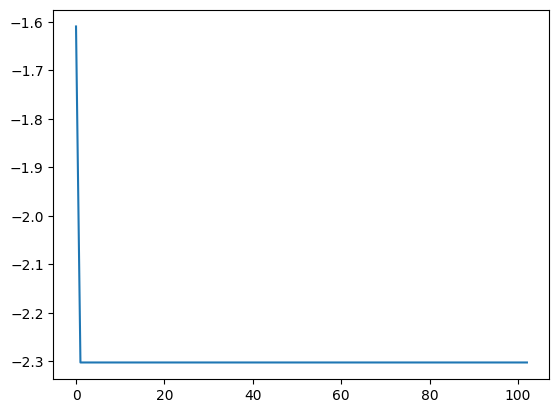

In [395]:
import matplotlib.pyplot as plt

plt.plot(problem.fn)

In [396]:
print(np.round(problem.x,3))
print(problem.fn[-1])

[ 9.9015e+01 -3.8000e-02  2.8200e-01  2.7540e+00]
-2.3024724547077495


In [397]:
x_k = np.array([99.991,0.003,0.003,0.003])
problem.grad_func(x=x_k,d=problem.default_w(T,delta))

(-2.302423721571916,
 array([-0.00500627,  0.00035255,  0.0003173 ,  0.00028557]))